<center><b> In this notebook, I have tried my best to explain the GANs with the help of illustrations and in-depth descriptions along with its implementation from scratch on the Stanford Dogs dataset. Feedback would be greatly appreciated :)</b></center>

<hr>

# Generative Adversarial Networks (GANs)

GANs are a type of neural network that we use to generate new images. They consist of two parts:

- **Generator**: We use this to create new images from random noise.
- **Discriminator**: We use this to evaluate the generated images against real-world examples.

Both parts start from scratch and learn together during training.<br>
<center>
<img src="https://miro.medium.com/v2/1*i4HTOtqH4qt9zIZUN43GoA.png" width="800" height="800"/></center><br>

## How GANs Work

We input a random noise signal into the **Generator** (G) and it outputs an image. The **Discriminator** (A) learns to distinguish between different objects or features. Once trained, it can identify whether an input image matches the features it has learned.

## GANs Process

In the first step, we input a random noise signal into the generator to create images. These images are used to train the discriminator, which outputs probabilities. We calculate errors and backpropagate them through the discriminator to update the weights.

Next, we train the generator using the images it created. The generator learns by tricking the discriminator into outputting false positives. We calculate errors and backpropagate them through the generator to update the weights.

In the second step, we further train the generator and discriminator. The generator improves by learning from its mistakes through backpropagation.


<center>
<img src="https://b2633864.smushcdn.com/2633864/wp-content/uploads/2020/11/keras_gans_steps.png?lossy=2&strip=1&webp=1" width="800" height="800"/></center><br>

<br><br>
# Importing the libraries

In [1]:
from __future__ import print_function
import time
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
from skimage.transform import resize

import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm

KeyboardInterrupt: 

### About the Dataset
We will be using Stanford Dogs dataset which contains images of 120 breeds of dogs from all over the world

Total dog pictures available: 120


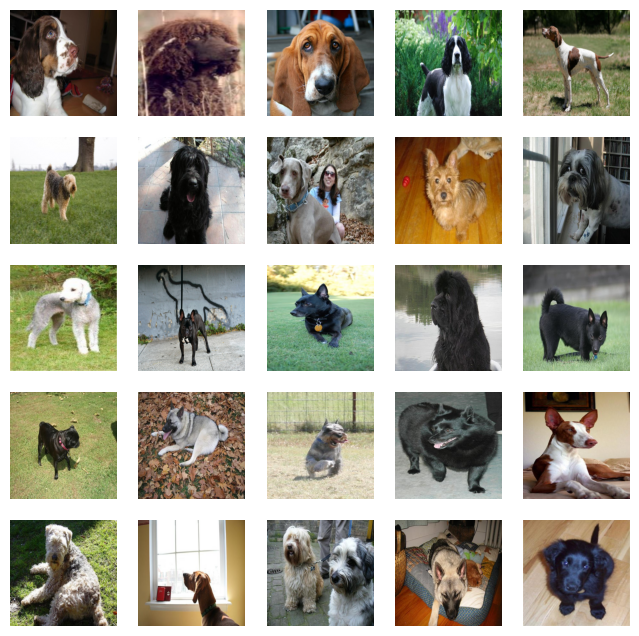

In [ ]:
import random
# Define the path to the directory containing dog images
PATH = '/kaggle/input/stanford-dogs-dataset/images/Images/'

# Get the list of image filenames in the directory
images = os.listdir(PATH)

# Display the count of dog pictures in the directory
print(f'Total dog pictures available: {len(os.listdir(PATH))}')

# Create subplots to display random images
fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(8,8))

# Iterate through the subplots and display random dog images
for indx, axis in enumerate(axes.flatten()):
    PATH_TEMP = random.choice(os.listdir(PATH))
    # Get a random index within the range of available images
    rnd_indx = np.random.randint(0, len(os.listdir(PATH+'/'+PATH_TEMP)))
    
    # Load and display the image using Matplotlib
    images = os.listdir(PATH+'/'+PATH_TEMP+'/')
    img = plt.imread(PATH+'/'+PATH_TEMP + '/'+images[rnd_indx])
    # Resize the image to a constant size (e.g., 64x64)
 
    img = resize(img, (400,400))
    imgplot = axis.imshow(img)
    axis.set_axis_off()  # Turn off the axis for better visualization



# Image Preprocessing
We apply transformations to our images, resize them to 64x64 pixels, and apply random color jittering, rotation, and horizontal flipping. We convert these transformed images into tensors and normalize them. We load these images in batches of 32 from a folder and shuffle them for randomness. This approach enhances the diversity and size of our dataset, improving our model’s robustness.

In [ ]:
batch_size = 32
image_size = 64

random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder(PATH, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)
                                           
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

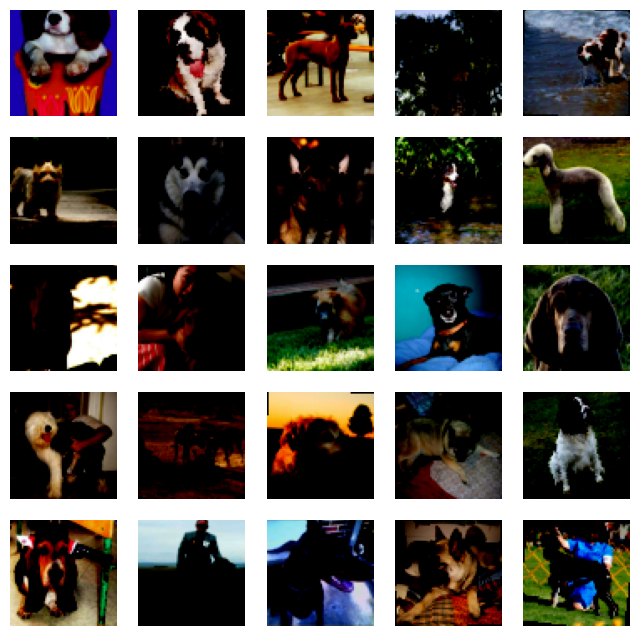

In [ ]:
fig, axs = plt.subplots(5,5, figsize = (8,8))

for i in range(5):
    for j in range(5):
        axs[i,j].imshow(imgs[5*i+j])
        axs[i,j].axis('off')

plt.show()

# Weights
### Defining the weights_init function

In [ ]:
def weights_init(m):
    """
    Takes as input a neural network m that will initialize all its weights.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Generator

In [ ]:
class G(nn.Module):
    def __init__(self):
        # Used to inherit the torch.nn Module
        super(G, self).__init__()
        # Meta Module - consists of different layers of Modules
        self.main = nn.Sequential(
                nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(True),
                nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(True),
                nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),
                nn.Tanh()
                )
        
    def forward(self, input):
        output = self.main(input)
        return output

# Creating the generator
netG = G()
netG.apply(weights_init)

G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

# Discriminator

In [ ]:
# Defining the discriminator
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.main = nn.Sequential(
                nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
                nn.Sigmoid()
                )
        
    def forward(self, input):
        output = self.main(input)
        # .view(-1) = Flattens the output into 1D instead of 2D
        return output.view(-1)
    
    
# Creating the discriminator
netD = D()
netD.apply(weights_init)


D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## Another setup

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

    
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        logits = self.model(imgs)
        out = torch.sigmoid(logits)
    
        return out.view(-1, 1)

# Training

In [ ]:
!mkdir results
!ls

mkdir: cannot create directory ‘results’: File exists
Annotation  __MACOSX  all-dogs	results


### Parameters

In [ ]:
batch_size = 32
LR_G = 0.001
LR_D = 0.0005

beta1 = 0.5
epochs = 100

real_label = 0.9
fake_label = 0
nz = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Initialize models and optimizers

In [ ]:
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=LR_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR_G, betas=(beta1, 0.999))

fixed_noise = torch.randn(25, nz, 1, 1, device=device)

G_losses = []
D_losses = []
epoch_time = []

**Plot Loss per EPOCH**
> plot_loss()

In [ ]:
def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

**Show generated images**
> show_generated_img()

In [ ]:
def show_generated_img(n_images=5):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
    
    figure, axes = plt.subplots(1, len(sample), figsize = (64,64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample[index]
        axis.imshow(image_array)
        
    plt.show()
    plt.close()

### Training Loop

/tmp/ipykernel_32/3139552926.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ii, (real_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):


  0%|          | 0/644 [00:00<?, ?it/s]

[1/100][322/644] Loss_D: 1.0422 Loss_G: 1.7507 D(x): 0.6499 D(G(z)): 0.3942 / 0.1566
[1/100][644/644] Loss_D: 1.1320 Loss_G: 0.9071 D(x): 0.3967 D(G(z)): 0.1957 / 0.4229


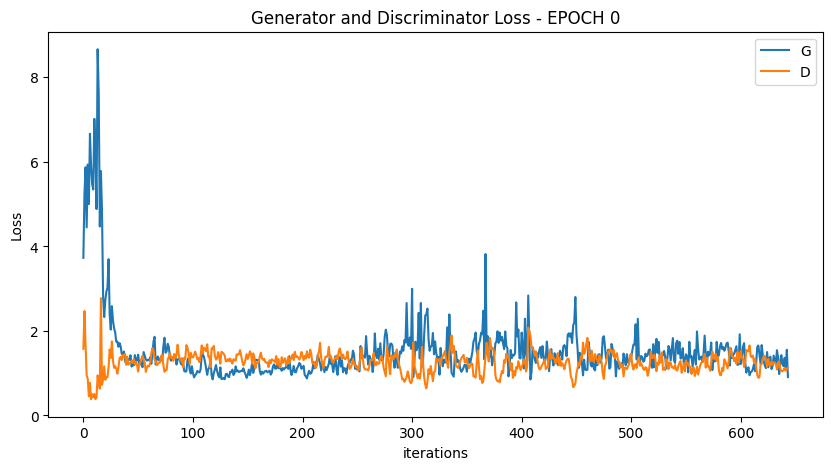

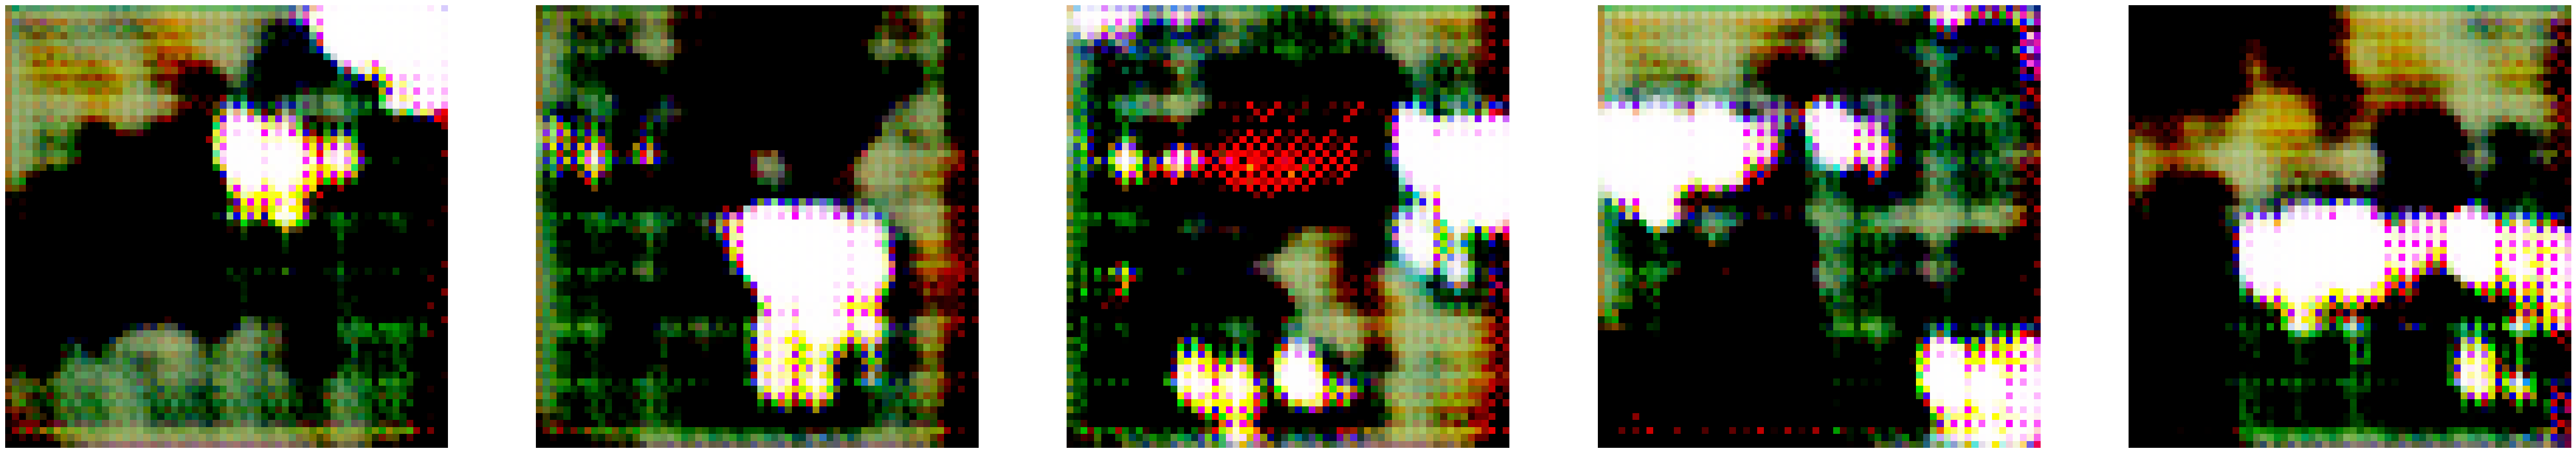

  0%|          | 0/644 [00:00<?, ?it/s]

[2/100][322/644] Loss_D: 1.2753 Loss_G: 1.3924 D(x): 0.5407 D(G(z)): 0.4244 / 0.2486
[2/100][644/644] Loss_D: 1.8861 Loss_G: 1.5799 D(x): 0.3133 D(G(z)): 0.4506 / 0.1832


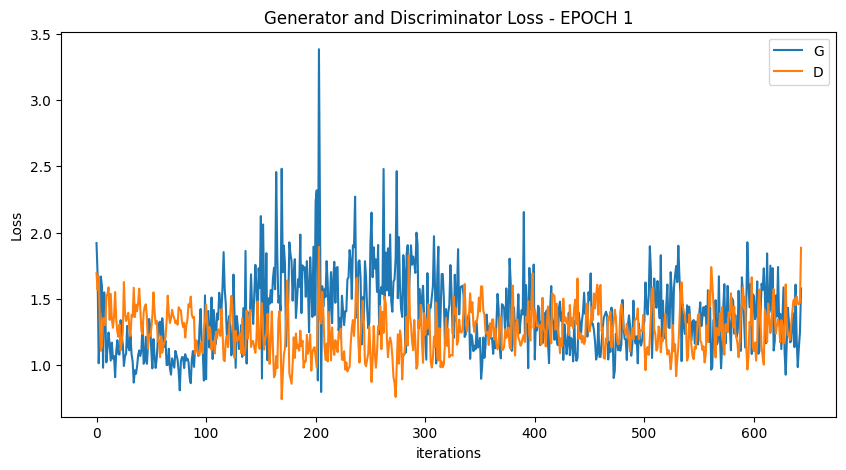

  0%|          | 0/644 [00:00<?, ?it/s]

[3/100][322/644] Loss_D: 1.2954 Loss_G: 1.2910 D(x): 0.4477 D(G(z)): 0.3377 / 0.2776
[3/100][644/644] Loss_D: 1.5824 Loss_G: 1.4344 D(x): 0.3044 D(G(z)): 0.3456 / 0.2235


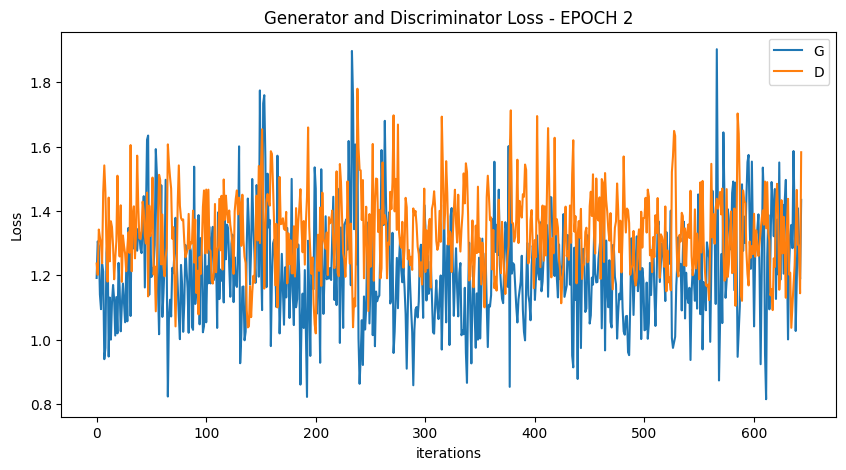

  0%|          | 0/644 [00:00<?, ?it/s]

[4/100][322/644] Loss_D: 1.4212 Loss_G: 1.0098 D(x): 0.4796 D(G(z)): 0.4752 / 0.3554
[4/100][644/644] Loss_D: 1.6285 Loss_G: 2.5884 D(x): 0.5349 D(G(z)): 0.6132 / 0.0588


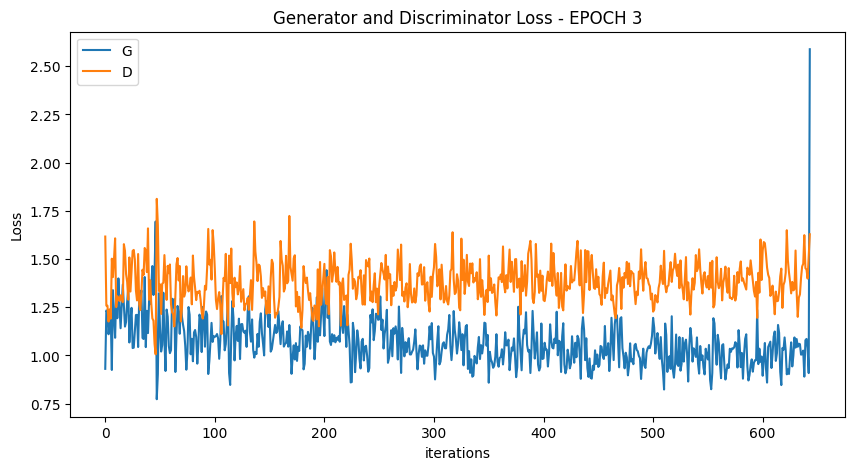

  0%|          | 0/644 [00:00<?, ?it/s]

[5/100][322/644] Loss_D: 1.4636 Loss_G: 1.0455 D(x): 0.4571 D(G(z)): 0.4727 / 0.3424
[5/100][644/644] Loss_D: 1.4198 Loss_G: 1.1388 D(x): 0.3828 D(G(z)): 0.3678 / 0.3043


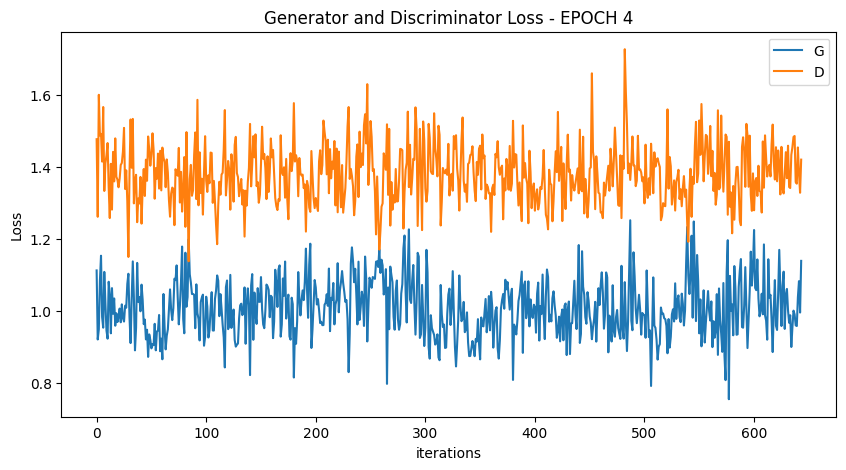

  0%|          | 0/644 [00:00<?, ?it/s]

[6/100][322/644] Loss_D: 1.2088 Loss_G: 1.2143 D(x): 0.5099 D(G(z)): 0.3833 / 0.2844
[6/100][644/644] Loss_D: 1.6401 Loss_G: 0.8858 D(x): 0.3344 D(G(z)): 0.4337 / 0.4023


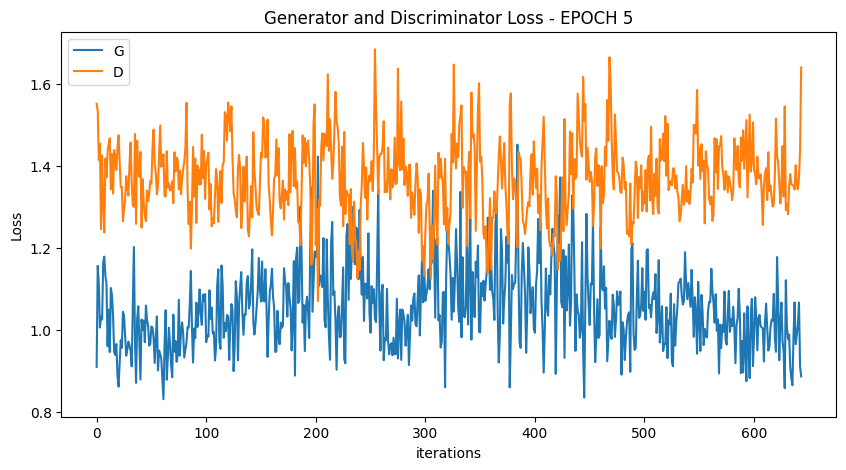

  0%|          | 0/644 [00:00<?, ?it/s]

[7/100][322/644] Loss_D: 1.2296 Loss_G: 1.2515 D(x): 0.5410 D(G(z)): 0.4313 / 0.2648
[7/100][644/644] Loss_D: 1.2845 Loss_G: 1.6877 D(x): 0.5369 D(G(z)): 0.4692 / 0.1716


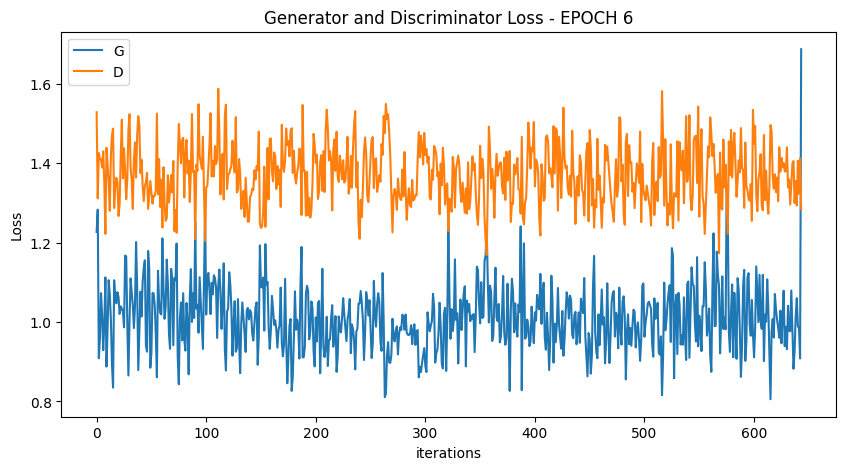

  0%|          | 0/644 [00:00<?, ?it/s]

[8/100][322/644] Loss_D: 1.2974 Loss_G: 1.2674 D(x): 0.5303 D(G(z)): 0.4565 / 0.2619
[8/100][644/644] Loss_D: 1.0012 Loss_G: 2.2575 D(x): 0.6258 D(G(z)): 0.3799 / 0.0847


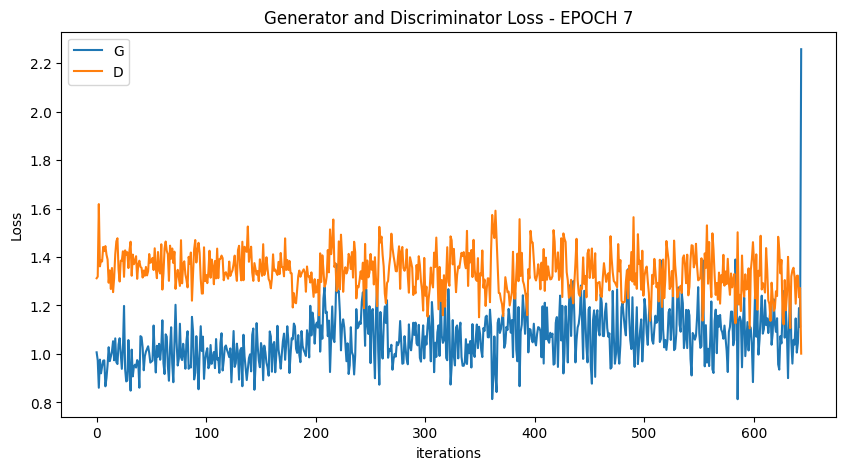

  0%|          | 0/644 [00:00<?, ?it/s]

[9/100][322/644] Loss_D: 1.5034 Loss_G: 1.0680 D(x): 0.5603 D(G(z)): 0.5595 / 0.3352
[9/100][644/644] Loss_D: 1.1998 Loss_G: 1.3237 D(x): 0.4499 D(G(z)): 0.3115 / 0.2472


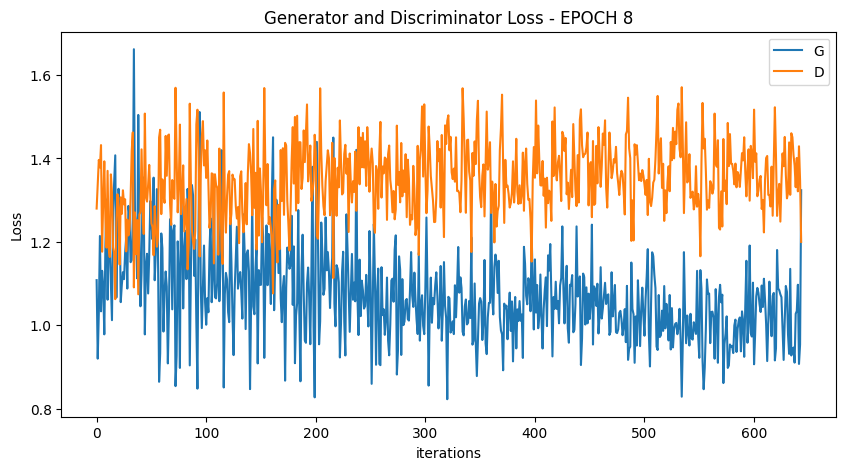

  0%|          | 0/644 [00:00<?, ?it/s]

[10/100][322/644] Loss_D: 1.4847 Loss_G: 1.0639 D(x): 0.4865 D(G(z)): 0.5115 / 0.3386
[10/100][644/644] Loss_D: 1.2118 Loss_G: 1.3092 D(x): 0.4588 D(G(z)): 0.3448 / 0.2625


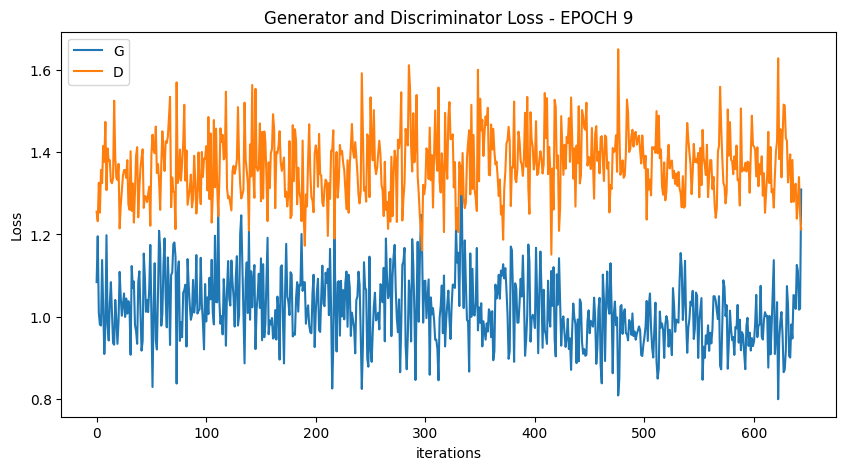

  0%|          | 0/644 [00:00<?, ?it/s]

[11/100][322/644] Loss_D: 1.4623 Loss_G: 0.8897 D(x): 0.4324 D(G(z)): 0.4638 / 0.3997
[11/100][644/644] Loss_D: 1.3471 Loss_G: 1.4985 D(x): 0.4829 D(G(z)): 0.4449 / 0.2021


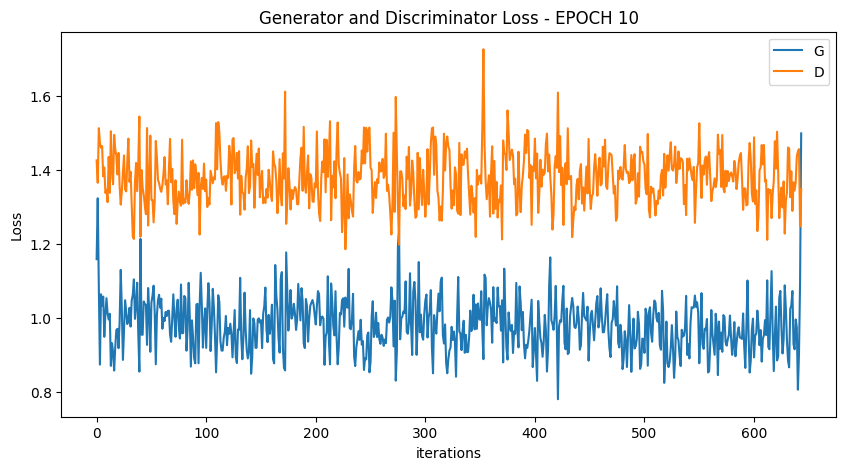

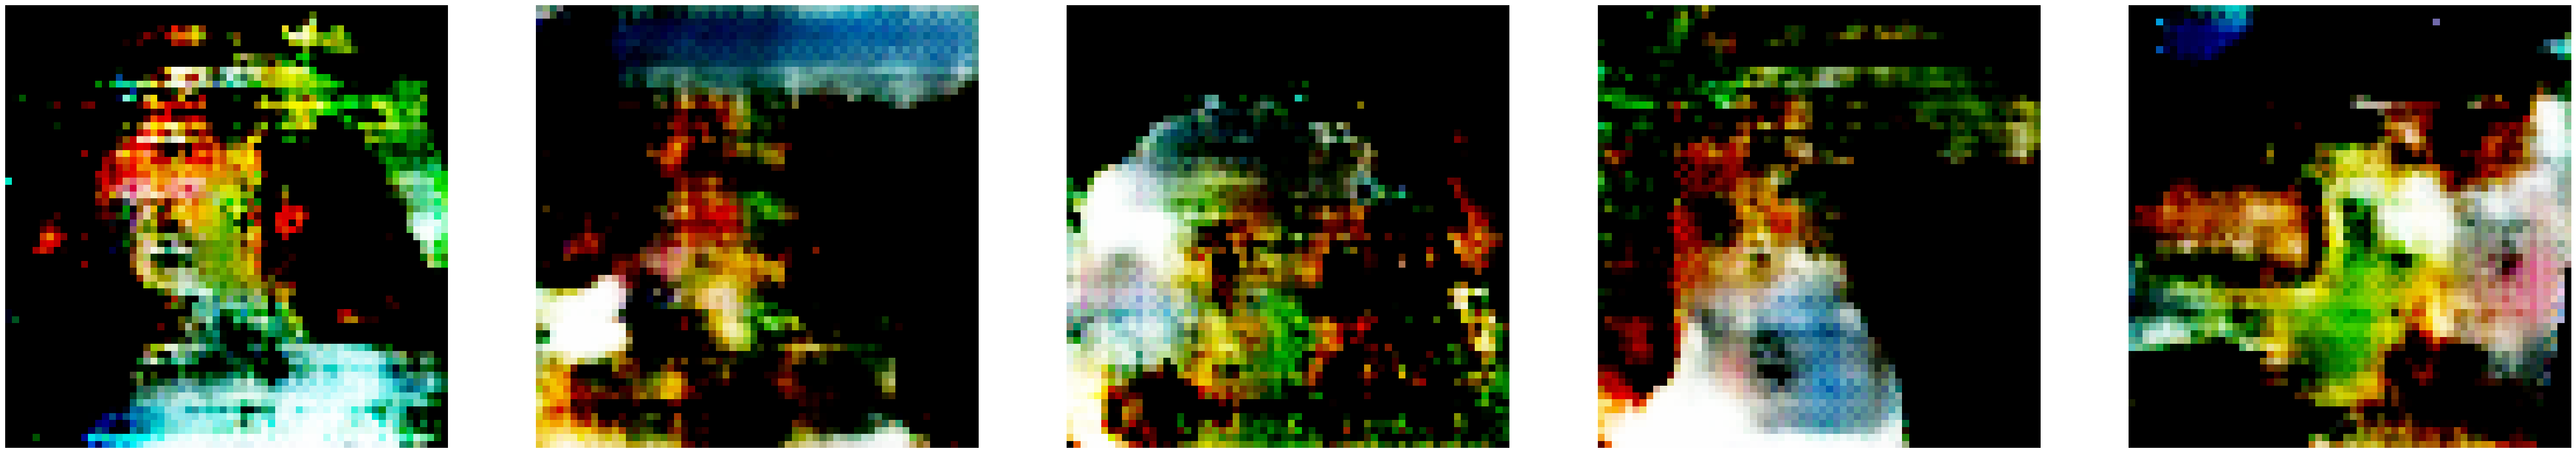

  0%|          | 0/644 [00:00<?, ?it/s]

[12/100][322/644] Loss_D: 1.2878 Loss_G: 0.9614 D(x): 0.5224 D(G(z)): 0.4526 / 0.3672
[12/100][644/644] Loss_D: 1.2681 Loss_G: 1.3536 D(x): 0.4820 D(G(z)): 0.3975 / 0.2343


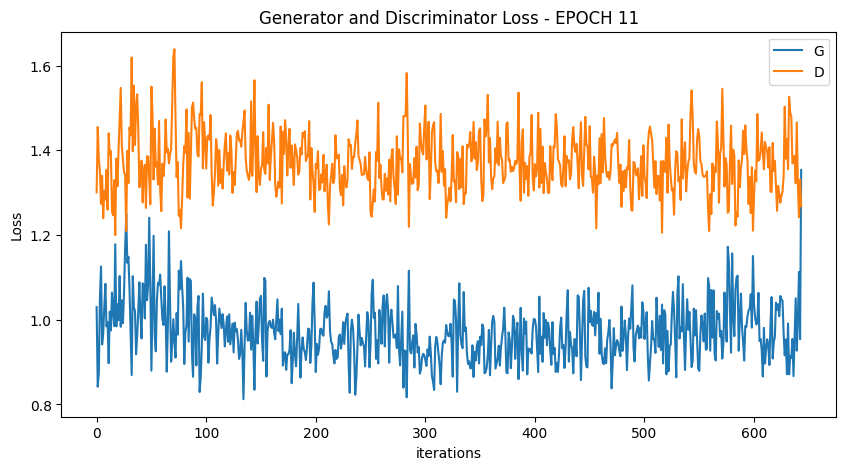

  0%|          | 0/644 [00:00<?, ?it/s]

[13/100][322/644] Loss_D: 1.3495 Loss_G: 1.0243 D(x): 0.4737 D(G(z)): 0.4410 / 0.3491


In [ ]:
for epoch in range(epochs):
    
    start = time.time()
    for ii, (real_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
    plot_loss (G_losses, D_losses, epoch)
    G_losses = []
    D_losses = []
    if epoch % 10 == 0:
        show_generated_img()

    epoch_time.append(time.time()- start)
    
#             valid_image = netG(fixed_noise)

In [ ]:
print (">> average EPOCH duration = ", np.mean(epoch_time))

# Generation example


In [ ]:
show_generated_img(7)

In [ ]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
    
im_batch_size = 50
n_images=10000

for i_batch in tqdm(range(0, n_images, im_batch_size)):
    gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))

In [ ]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for i, j in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(j)